In [14]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm
import time
from matplotlib.cm import inferno
from torch.optim.lr_scheduler import StepLR
import cv2
import pandas as pd

In [15]:
data_path = '/kaggle/input/birds-25/Birds_25'

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])


In [4]:
train_dataset = datasets.ImageFolder(root=data_path + '/train', transform=transform)
val_dataset = datasets.ImageFolder(root=data_path + '/val', transform=transform)
test_dataset = datasets.ImageFolder(root=data_path + '/test', transform=transform)


In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4,drop_last=True)


In [4]:
class batch_nomalization(nn.Module):
    def __init__(self, num_features, momentum=0.1):
        super(batch_nomalization, self).__init__()
        self.momentum = momentum
        self.norm_across = (0, 2, 3) 

        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

        self.register_buffer('running_mean', torch.zeros(1, num_features, 1, 1))
        self.register_buffer('running_var', torch.ones(1, num_features, 1, 1))

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=self.norm_across, keepdim=True)
            var = x.var(dim=self.norm_across, keepdim=True, unbiased=False)
            n = x.numel() / x.size(1)   # Update running estimates
            self.running_mean =  (1 - self.momentum) * self.running_mean +self.momentum * mean 
            self.running_var =   (1 - self.momentum) * self.running_var + self.momentum * (n / (n - 1)) * var
        else:
            mean = self.running_mean
            var = self.running_var

        return self.gamma * ((x - mean) / torch.sqrt(var + 1e-5)) + self.beta


class Instance_Normalization(nn.Module):
    def __init__(self,num_features):
        super(Instance_Normalization, self).__init__()
        self.shape=(1,num_features,1,1)
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self,x):
        var = x.var(dim=(2,3), keepdim=True)
        mean = x.mean(dim=(2,3), keepdim=True)
        return (self.gamma * ((x-mean)/torch.sqrt(var + 1e-5)) + self.beta)


class layer_Normalization(nn.Module):
    def __init__(self,num_features):
        super(layer_Normalization, self).__init__()
        self.shape=(1,num_features,1,1)
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    
    def forward(self,x):
        var = x.var(dim=(1,2,3), keepdim=True,unbiased=False)
        mean = x.mean(dim=(1,2,3), keepdim=True)
        return (self.gamma * ((x-mean)/torch.sqrt(var + 1e-5)) + self.beta)
    
    
class BatchInstanceNorm(nn.Module):
    def __init__(self, num_features, momentum=0.1):
        super(BatchInstanceNorm, self).__init__()
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.register_buffer('running_mean', torch.zeros(1, num_features, 1, 1))
        self.register_buffer('running_var', torch.ones(1, num_features, 1, 1))

    def forward(self, x):
        if self.training:
            var_bn = x.var(dim=(0, 2, 3), keepdim=True, unbiased=False)
            mean_bn = x.mean(dim=(0, 2, 3), keepdim=True)
            self.running_mean = (1 - self.momentum) * self.running_mean +  self.momentum * mean_bn 
            self.running_var =   (1 - self.momentum) * self.running_var + self.momentum * var_bn
        else:
            mean_bn = self.running_mean
            var_bn = self.running_var

        x_bn = (x - mean_bn) / torch.sqrt(var_bn + 1e-5)
        mean_in = x.mean(dim=(2, 3), keepdim=True)
        var_in = x.var(dim=(2, 3), keepdim=True, unbiased=False)
        x_in = (x - mean_in) / torch.sqrt(var_in + 1e-5)
        x = 0.5 * x_bn + (1 - 0.5) * x_in
        return ( x * self.gamma + self.beta)

    
    
class GroupNorm(nn.Module):
    def __init__(self, num_features, group=4):
        super(GroupNorm, self).__init__()
        self.group = group
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.shape
        x = x.view(N, self.group, C // self.group, H, W)
        mean = x.mean(dim=(2, 3, 4), keepdim=True)
        var = x.var(dim=(2, 3, 4), keepdim=True, unbiased=False)
        x_normalized = (x - mean) / torch.sqrt(var + 1e-5)
        x = x_normalized.view(N, C, H, W)
        return (x * self.gamma + self.beta)
    
    
class no_norm(nn.Module):
    def __init__(self,num_features):
        super(no_norm,self).__init__()
    def forward(self,x):
        return x


In [5]:
def layer_normalization(dim, norm_type):
    if norm_type == "inbuilt":
        return nn.BatchNorm2d(dim)
    elif norm_type=="bn":
        return batch_nomalization(dim)
    elif norm_type=="in":
        return Instance_Normalization(dim)
    elif norm_type=="ln":
        return layer_Normalization(dim)
    elif norm_type=="nn":
        return no_norm(dim)
    elif norm_type=="bin":
        return BatchInstanceNorm(dim)
    elif norm_type=="gn":
        return GroupNorm(dim)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None, norm_type="inbuilt"):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, bias=False)
        self.bn1 = layer_normalization(out_channels, norm_type)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size//2, bias=False)
        self.bn2 = layer_normalization(out_channels, norm_type)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, n_channels=[16, 32, 64], n_layers=[2, 2, 2], n_classes=25, norm_type="torch_bn", input_size=256):
        super(ResNet, self).__init__()
        self.in_channels = n_channels[0]
        self.conv = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = layer_normalization(self.in_channels, norm_type)
        self.relu = nn.ReLU(inplace=True)
        
        self.layers = nn.ModuleList()
        for index, num_blocks in enumerate(n_layers):
            out_channels = n_channels[index]
            strides = [2] + [1] * (num_blocks - 1)
            for stride in strides:
                downsample = None
                if stride != 1 or self.in_channels != out_channels:
                    downsample = nn.Sequential(
                        nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                        layer_normalization(out_channels, norm_type),
                    )
                self.layers.append(ResidualBlock(self.in_channels, out_channels, stride=stride, downsample=downsample, norm_type=norm_type))
                self.in_channels = out_channels
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out_channels, n_classes)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
accuracy_train=[]
microf1_train=[]
macrof1_train=[]
error_train=[]
loss_train=[]
precision_score_train=[]
accuracy_validation=[]
microf1_validation=[]
macrof1_validation=[]
error_validation=[]
loss_validation=[]
precision_score_validation=[]



In [9]:
def store_results_train(actual,predicted,epoch,l):
    accuracy = accuracy_score(actual, predicted)
    micro_f1 = f1_score(actual, predicted, average='micro')
    macro_f1 = f1_score(actual, predicted, average='macro')
    precision = precision_score(actual, predicted, average='macro')
    error = 1 - accuracy
    accuracy_train.append(accuracy)
    microf1_train.append(micro_f1)
    macrof1_train.append(macro_f1)
    error_train.append(error)
    precision_score_train.append(precision)
    loss_train.append(l)
    print("====================train_data======================")
    print(f"for epoch {epoch} accuracy:{accuracy},loss:{l}")
    print("====================================================")
    
def store_results_validation(actual,predicted,epoch,l):
    accuracy = accuracy_score(actual, predicted)
    micro_f1 = f1_score(actual, predicted, average='micro')
    macro_f1 = f1_score(actual, predicted, average='macro')
    precision = precision_score(actual, predicted, average='macro')
    error = 1 - accuracy
    accuracy_validation.append(accuracy)
    microf1_validation.append(micro_f1)
    macrof1_validation.append(macro_f1)
    error_validation.append(error)
    precision_score_validation.append(precision)
    loss_validation.append(l)
    print("====================validation_data======================")
    print(f"for epoch {epoch} accuracy:{accuracy},loss:{l}")
    print("====================================================")
    

def store_train_results_to_csv(accuracy_train, microf1_train, macrof1_train, precision_score_train, error_train, loss_train, filename="training_results.csv"):
    data = {
        "Accuracy": accuracy_train,
        "Micro F1 Score": microf1_train,
        "Macro F1 Score": macrof1_train,
        "Precision": precision_score_train,
        "Error": error_train,
        "Loss": loss_train
    }
    
    df = pd.DataFrame(data)
    
    df.to_csv(filename, index=False)


def store_validation_results_to_csv(accuracy_validation, microf1_validation, macrof1_validation, precision_score_validation, error_validation,loss_validation,  filename="validation_results.csv"):
    data = {
        "Accuracy": accuracy_validation,
        "Micro F1 Score": microf1_validation,
        "Macro F1 Score": macrof1_validation,
        "Precision": precision_score_validation,
        "Error": error_validation,
        "Loss":loss_validation
    }
    
    df = pd.DataFrame(data)
    
    df.to_csv(filename, index=False)

def store(name):
    store_train_results_to_csv(accuracy_train, microf1_train, macrof1_train, precision_score_train, error_train, loss_train, name+"_training_results.csv")
    store_validation_results_to_csv(accuracy_validation, microf1_validation, macrof1_validation, precision_score_validation, error_validation,loss_validation, name+"_validation_results.csv")
    
def plot_lists(*lists, labels=None, title='Plot of Lists',name=None, xlabel='Epoch', ylabel='Value', legend=True):
    plt.figure(figsize=(10, 6)) 
    for i, lst in enumerate(lists):
        plt.plot(lst, label=labels[i] if labels else f'List {i + 1}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if legend:
        plt.legend()
    
    plt.grid(True)
    plt.savefig(name)
    plt.show()
    
def saveall(name):
    store(name)
    plot_lists(accuracy_train, microf1_train, macrof1_train, precision_score_train, error_train, loss_train,
           labels=['Accuracy', 'Micro F1', 'Macro F1', 'Precision', 'Error', 'Loss'],name=name+"_train.png")
    plot_lists(accuracy_validation, microf1_validation, macrof1_validation, precision_score_validation, error_validation,loss_validation,
           labels=['Accuracy', 'Micro F1', 'Macro F1', 'Precision', 'Error', 'Loss'],name=name+"_validation.png")
    


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tot_batches=len(train_loader)
print(device)

In [ ]:
def inverse_normalize(img_tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )

    return inv_normalize(img_tensor)




def gradcam2( sample_x, sample_y, target_layer,model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    global gradients, activations
    gradients, activations = None, None
    
    def backward_hook(module, grad_input, grad_output):
      global gradients 
      gradients = grad_output
    def forward_hook(module, args, output):
      global activations
      activations = output
        
    forward_handle = target_layer.register_full_backward_hook(backward_hook)  #prepend=False
    backward_handle = target_layer.register_forward_hook(forward_hook)
    
    
    output = model(sample_x.unsqueeze(0)) 
    sample_y = torch.tensor([sample_y]).to(device)
    loss = criterion(output,sample_y) 
    loss.backward() 
    
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    forward_handle.remove()
    backward_handle.remove()
    
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)

    heatmap /= torch.max(heatmap)
    heatmap=heatmap.to('cpu')
    heatmap=heatmap.detach().numpy()
    original_image_tensor = inverse_normalize(sample_x)
    original_image = transforms.ToPILImage()(original_image_tensor)
    original_image=np.array(original_image)
    heatmap_resized = cv2.resize(heatmap, (256, 256), interpolation=cv2.INTER_LINEAR)
    heatmap_normalized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))
    heatmap_colored = inferno(heatmap_normalized)[:, :, :3] 
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
    combined_img = cv2.addWeighted(original_image, 0.5, heatmap_colored, 0.5, 0)

    return combined_img

def collect_req_images_from_validation_data(loader,model):
    mapping={2:0,7:1,13:2,18:3,19:4,22:5,23:6}
    correctly_classified=[[] for _ in range(7)]
    incorrectly_classified=[[] for _ in range(7)]
    for i,(x,y) in enumerate(loader) :
#         print(i)
        x=x.to(device)
        for j,img in enumerate(x) :
            y_orig=y[j].item()
            y_pred=torch.argmax(model(img.unsqueeze(0))).item()
#                 print(y_orig,y_pred)
            if y_orig in mapping:
                if (y_orig==y_pred) and len(correctly_classified[mapping[y_orig]])<5:
                    correctly_classified[mapping[y_orig]].append(gradcam2(img,y[j],model.layers[-1],model))
                elif (y_orig!=y_pred) and len(incorrectly_classified[mapping[y_orig]])<5:
                    incorrectly_classified[mapping[y_orig]].append(gradcam2(img,y[j],model.layers[-1],model))
    return correctly_classified,incorrectly_classified


if(False):
    p="/kaggle/input/birds-models/models/sgd_instant_bn.pth"
    old=torch.load(p)
    m=ResNet(norm_type="bn")
    m.load_state_dict(old)
    m=m.to(device)
    m.eval()
    correctly_classified,incorrectly_classified=collect_req_images_from_validation_data(test_loader,m)
    for cls,i in enumerate(correctly_classified):
        name=str(cls)+"_1_"
        for img_c,j in enumerate(i):
            p=name+str(img_c)+".png"
            cv2.imwrite(p,j)
    for cls,i in enumerate(incorrectly_classified):
        name=str(cls)+"_0_"
        for img_c,j in enumerate(i):
            p=name+str(img_c)+".png"
            cv2.imwrite(p,j)


In [11]:
def train(epoch,norm):
    m=ResNet(norm_type=norm)
    m=m.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(m.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
    st=time.time()
    for i in range(epoch):
        m.train()
        predicted=[]
        actual=[]
        loss=[]
        for j,(x,y) in enumerate(train_loader):
            
            optimizer.zero_grad()
            x=x.to(device)
            # print(x.shape)
            y=y.to(device)
            y_pred=m(x)
            actual.extend(y.squeeze().tolist())
            predicted.extend(torch.argmax(y_pred,dim=1).squeeze().tolist())
            # print(y_pred.shape,y)
            l=criterion(y_pred,y)
            l.backward()
            optimizer.step()
            loss.append(l.item())
            if(j%300==0) :
                print(f"accuracy at epoch : {i} batch {j}/{tot_batches} : {accuracy_score(actual,predicted)} time : {(time.time()-st)/60}min",)
#         scheduler.step()
        store_results_train(actual,predicted,i,np.mean(loss))
        # plt.plot(loss)
        m.eval()
        predicted=[]
        actual=[]
        loss=[]
        for j,(x,y) in enumerate(val_loader):
            x=x.to(device)
            y=y.to(device)
            actual.extend(y.squeeze().tolist())
            y_pred=m(x)
            l=criterion(y_pred,y)
            loss.append(l.item())
            predicted.extend(torch.argmax(y_pred,dim=1).squeeze().tolist())
        store_results_validation(actual,predicted,i,np.mean(loss))
    torch.save(m.state_dict(), norm+'.pth')


accuracy at epoch : 0 batch 0/919 : 0.03125 time : 0.02656263510386149min
accuracy at epoch : 0 batch 300/919 : 0.12084717607973422 time : 0.522652820746104min
accuracy at epoch : 0 batch 600/919 : 0.14969841930116473 time : 1.0202690720558167min
accuracy at epoch : 0 batch 900/919 : 0.1733490566037736 time : 1.5167863011360168min
====================train_data======================
for epoch 0 accuracy:0.1745443416757345,loss:2.778876805590857
====================validation_data======================
for epoch 0 accuracy:0.23532919847328243,loss:2.528447124339242
accuracy at epoch : 1 batch 0/919 : 0.4375 time : 1.921394447485606min
accuracy at epoch : 1 batch 300/919 : 0.25332225913621265 time : 2.418324025472005min
accuracy at epoch : 1 batch 600/919 : 0.25779950083194675 time : 2.917730716864268min
accuracy at epoch : 1 batch 900/919 : 0.26616259711431745 time : 3.418468161424001min
====================train_data======================
for epoch 1 accuracy:0.2672062023939064,loss:2.

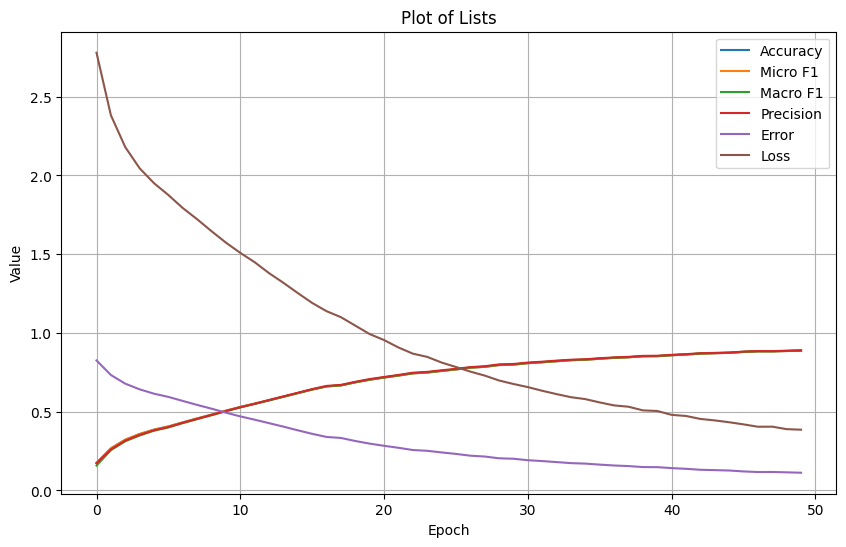

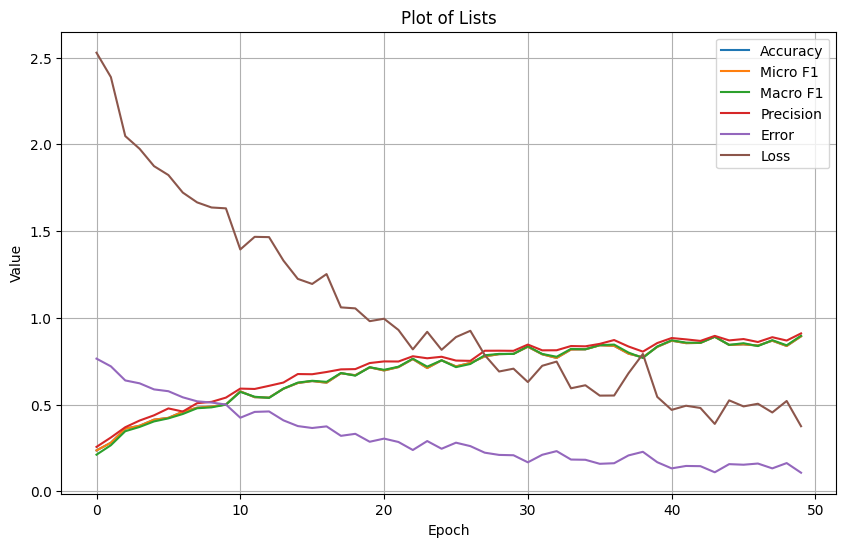

accuracy at epoch : 0 batch 0/919 : 0.0 time : 0.019378697872161864min
accuracy at epoch : 0 batch 300/919 : 0.055440199335548175 time : 0.7191613713900248min
accuracy at epoch : 0 batch 600/919 : 0.07856697171381032 time : 1.4168620506922405min
accuracy at epoch : 0 batch 900/919 : 0.09652469478357381 time : 2.1156001488367715min
====================train_data======================
for epoch 0 accuracy:0.09701441784548422,loss:3.168571367876055
====================validation_data======================
for epoch 0 accuracy:0.15362595419847327,loss:3.081453997670239


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy at epoch : 1 batch 0/919 : 0.09375 time : 2.41539074977239min
accuracy at epoch : 1 batch 300/919 : 0.1508513289036545 time : 3.116652790705363min
accuracy at epoch : 1 batch 600/919 : 0.1521942595673877 time : 3.8165192445119223min
accuracy at epoch : 1 batch 900/919 : 0.15704772475027748 time : 4.51451378663381min
====================train_data======================
for epoch 1 accuracy:0.1573721436343852,loss:2.8918507431225366
====================validation_data======================
for epoch 1 accuracy:0.18726145038167938,loss:2.683491892487038


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy at epoch : 2 batch 0/919 : 0.1875 time : 4.80768392086029min
accuracy at epoch : 2 batch 300/919 : 0.18926495016611294 time : 5.50734904607137min
accuracy at epoch : 2 batch 600/919 : 0.19815931780366056 time : 6.202238305409749min
accuracy at epoch : 2 batch 900/919 : 0.20359322974472807 time : 6.897643490632375min
====================train_data======================
for epoch 2 accuracy:0.20385609357997825,loss:2.5755699770494695
====================validation_data======================
for epoch 2 accuracy:0.21731870229007633,loss:2.4531898773808516


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy at epoch : 3 batch 0/919 : 0.1875 time : 7.193366388479869min
accuracy at epoch : 3 batch 300/919 : 0.23100083056478404 time : 7.893083695570628min
accuracy at epoch : 3 batch 600/919 : 0.2394446755407654 time : 8.59347010453542min
accuracy at epoch : 3 batch 900/919 : 0.24982658157602664 time : 9.291653756300608min
====================train_data======================
for epoch 3 accuracy:0.2496259521218716,loss:2.3673270309062207
====================validation_data======================
for epoch 3 accuracy:0.27075381679389315,loss:2.2534620782346217


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy at epoch : 4 batch 0/919 : 0.125 time : 9.580868792533874min
accuracy at epoch : 4 batch 300/919 : 0.2866486710963455 time : 10.283583645025889min
accuracy at epoch : 4 batch 600/919 : 0.28956946755407653 time : 10.984633652369181min
accuracy at epoch : 4 batch 900/919 : 0.2985224750277469 time : 11.684623444080353min
====================train_data======================
for epoch 4 accuracy:0.2988302502720348,loss:2.207305158702282
====================validation_data======================
for epoch 4 accuracy:0.3376669847328244,loss:2.130631859748418
accuracy at epoch : 5 batch 0/919 : 0.4375 time : 11.980465706189474min
accuracy at epoch : 5 batch 300/919 : 0.3188330564784053 time : 12.680430539449056min
accuracy at epoch : 5 batch 600/919 : 0.3301268718801997 time : 13.376206994056702min
accuracy at epoch : 5 batch 900/919 : 0.3425360710321865 time : 14.070868508021038min
====================train_data======================
for epoch 5 accuracy:0.3433759521218716,loss:2.0752

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy at epoch : 6 batch 0/919 : 0.40625 time : 14.364863725503286min
accuracy at epoch : 6 batch 300/919 : 0.3793604651162791 time : 15.065444648265839min
accuracy at epoch : 6 batch 600/919 : 0.38331946755407653 time : 15.760682006676992min
accuracy at epoch : 6 batch 900/919 : 0.3874861265260821 time : 16.456797901789347min
====================train_data======================
for epoch 6 accuracy:0.3875816104461371,loss:1.9453555995413996
====================validation_data======================
for epoch 6 accuracy:0.4066078244274809,loss:1.8588690493853037
accuracy at epoch : 7 batch 0/919 : 0.28125 time : 16.750059600671133min
accuracy at epoch : 7 batch 300/919 : 0.4092607973421927 time : 17.45145609776179min
accuracy at epoch : 7 batch 600/919 : 0.40999376039933444 time : 18.14876283009847min
accuracy at epoch : 7 batch 900/919 : 0.415788013318535 time : 18.845410072803496min
====================train_data======================
for epoch 7 accuracy:0.41641730141458105,loss:1

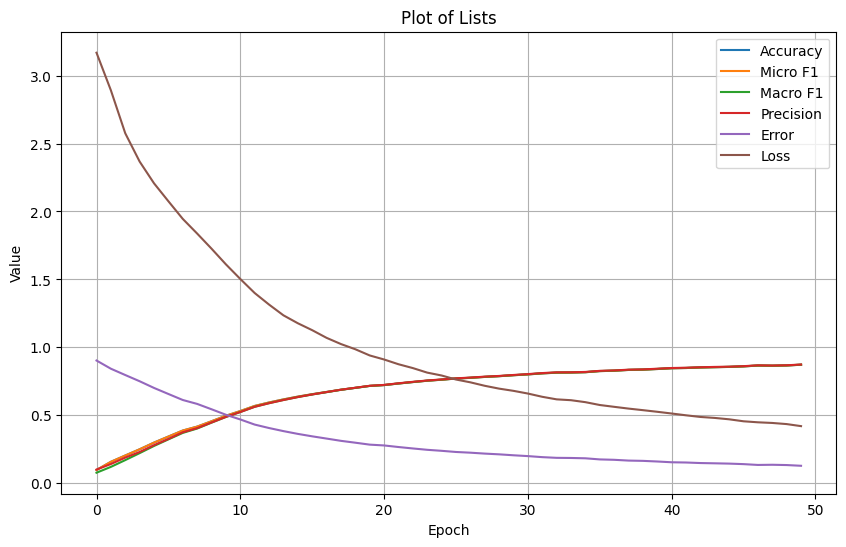

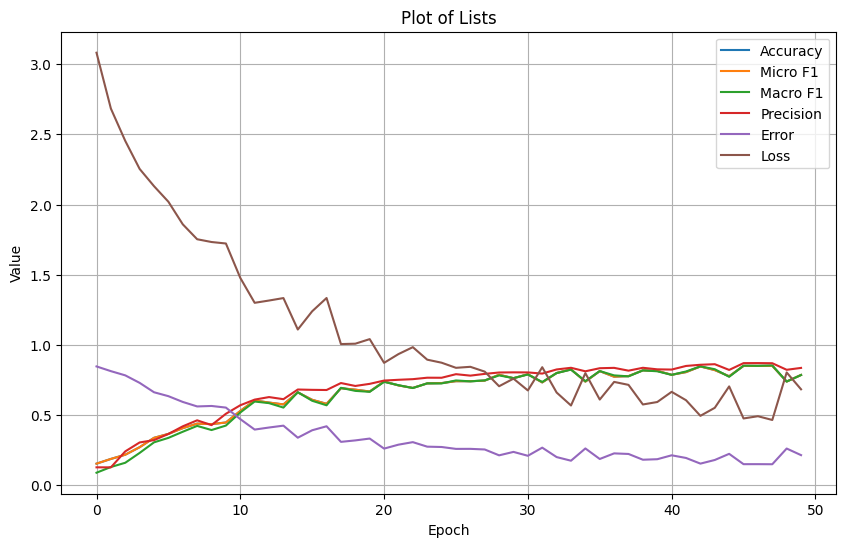

In [13]:
run=["bn","bin"]
for i in run:
    accuracy_train.clear()
    microf1_train.clear()
    macrof1_train.clear()
    error_train.clear()
    loss_train.clear()
    precision_score_train.clear()
    accuracy_validation.clear()
    microf1_validation.clear()
    macrof1_validation.clear()
    error_validation.clear()
    loss_validation.clear()
    precision_score_validation.clear()
    train(50,i)
    saveall(i)